# Análisis de predicción de Demanda usando Modelos SARIMA y Prophet

Por: Hoover A. Serna.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
warnings.filterwarnings('ignore')

demand_ds = pd.read_csv('/content/dataset_demand_acumulate.csv') # Ajustar la ruta al relativa al lugar donde se encuentran los archivos.
demand_ds.head()

,year_month,Demand
0,2017-01,1211.009490
1,2017-02,1660.584649
2,2017-03,3182.587014
3,2017-04,3506.515270
4,2017-05,4554.082280


In [3]:
new_deman_ds = demand_ds.copy()
new_deman_ds = new_deman_ds.iloc[:int(len(new_deman_ds) * 1)]

In [4]:
def check_stationarity(data):
  result = adfuller(data, autolag='AIC')
  p_value = result[1]
  print('ADF Statistic:', result[0])
  print('p-value:', p_value)
  print('Stationary' if p_value < 0.05 else 'Non-Stationary')

Validamos la estacionalidad de la serie.

* Los datos se toman acumulados, por año, ya que presentan mucha aleatoriedad si se analizan mes a mes.

In [5]:
check_stationarity(demand_ds['Demand'])

ADF Statistic: -4.4410161879428465
p-value: 0.00025096210164983945
Stationary


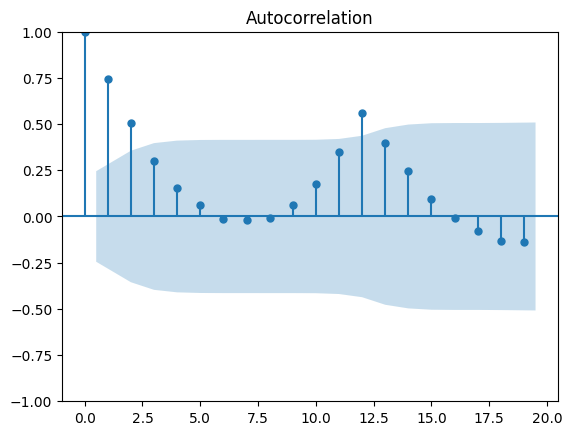

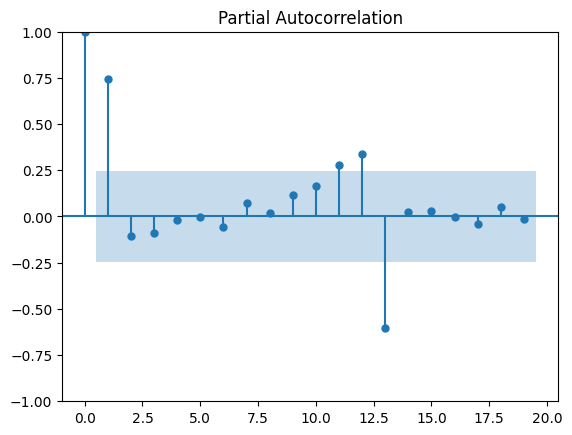

In [6]:
plot_acf(demand_ds['Demand'])
plot_pacf(demand_ds['Demand'])
plt.show()

In [7]:
demand_list_size = len(demand_ds)
print(demand_list_size)

64


In [36]:
def graph_scenario(demand, forecast, mape):

  plt.figure(figsize=(12, 6))
  plt.plot(demand['Demand'], label='Original Demand', marker='o', linestyle='-')
  plt.axvline(x=(len(demand)- len(forecast)), color='red', linestyle='--', linewidth=2, label='Corte de Entrenamiento')
  plt.plot(forecast, label=f'Forecast Model (Test - MAPE :{mape:.2f})', color='green', marker='o', linestyle='-')
  plt.title('Demand Forecast')
  plt.xlabel('Year-Month')
  plt.ylabel('Demand')
  plt.legend()
  plt.grid(True)
  plt.show()

In [34]:
p,d,q = 1,1,2 # Mejor Resultado
# p,d,q = 0,1,2
# P,D,Q,s = 1,1,1,6 Mejor Resultado
P,D,Q,s = 1,1,1,6


Tamaño del conjunto de prueba: 2 Entrenamiento: 62
***************************************************
***************************************************


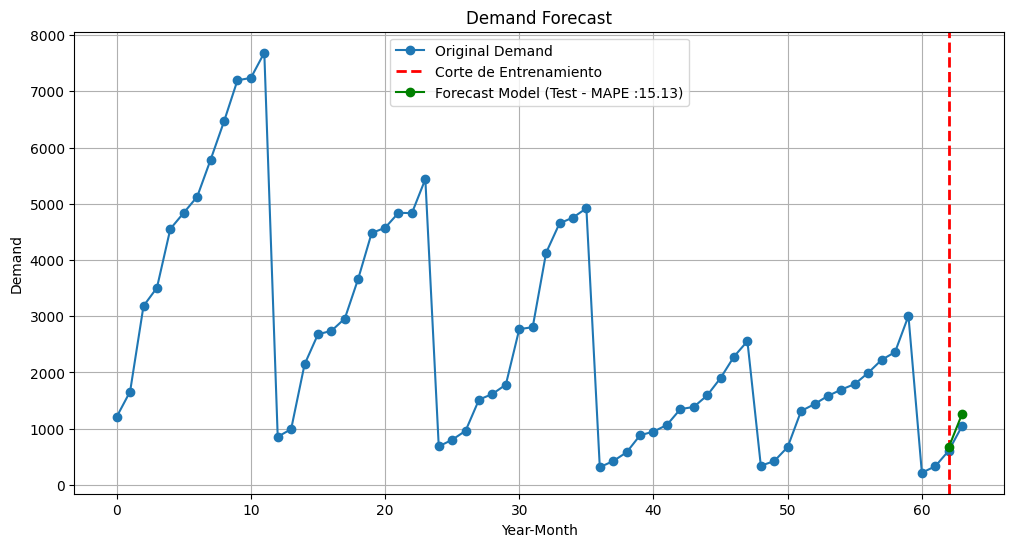

***************************************************
***************************************************


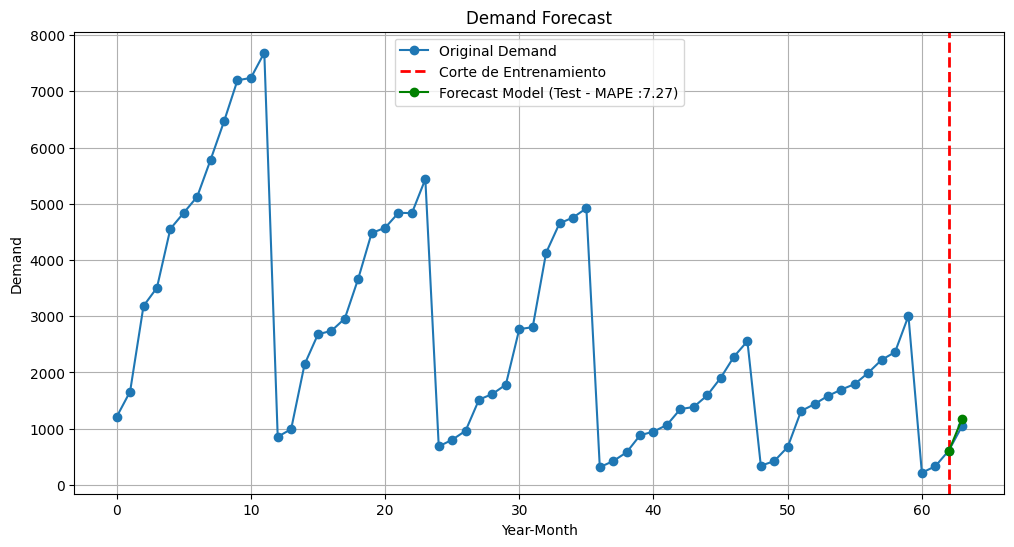

***************************************************
***************************************************

Tamaño del conjunto de prueba: 3 Entrenamiento: 61
***************************************************
***************************************************


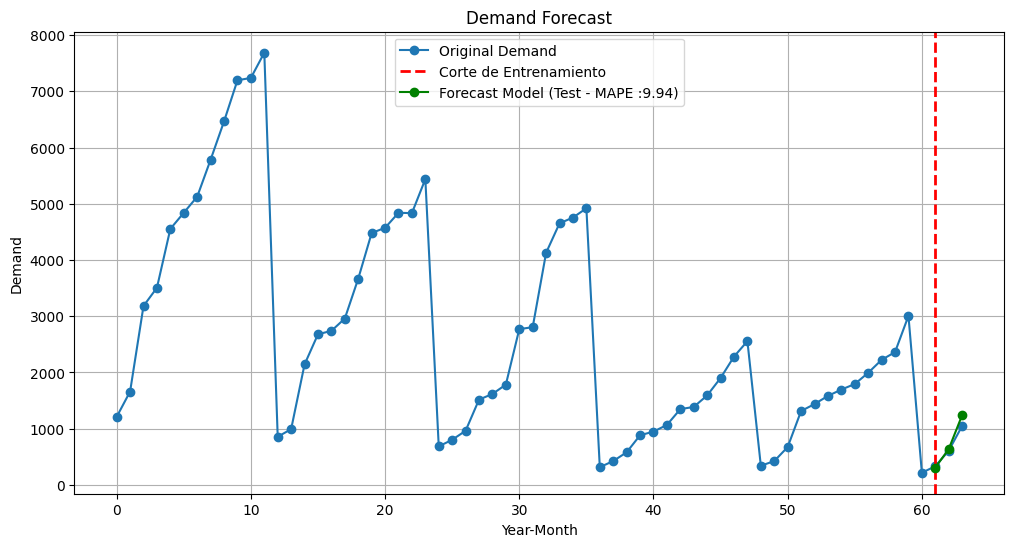

***************************************************
***************************************************


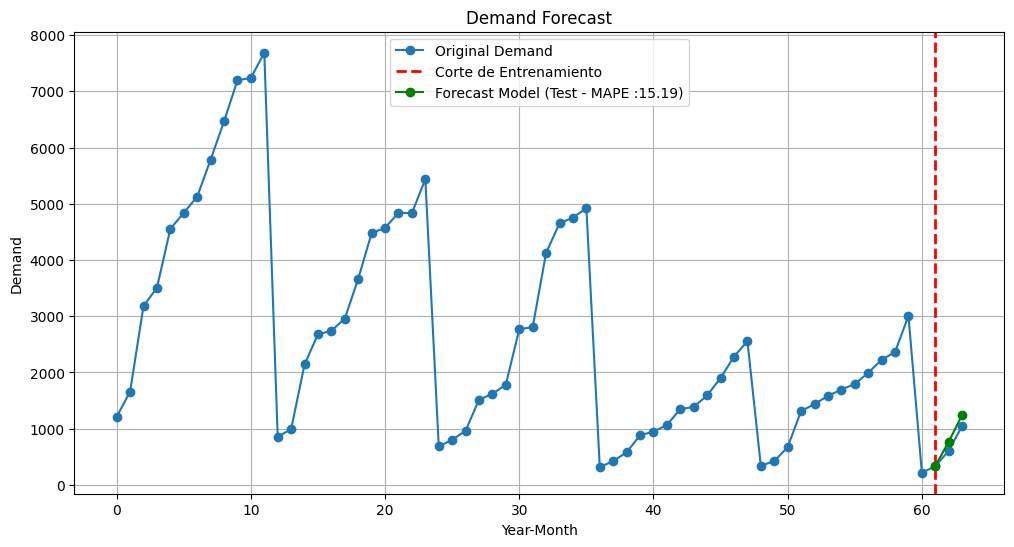

***************************************************
***************************************************

Tamaño del conjunto de prueba: 4 Entrenamiento: 60
***************************************************
***************************************************
***************************************************
***************************************************
***************************************************
***************************************************

Tamaño del conjunto de prueba: 5 Entrenamiento: 59
***************************************************
***************************************************


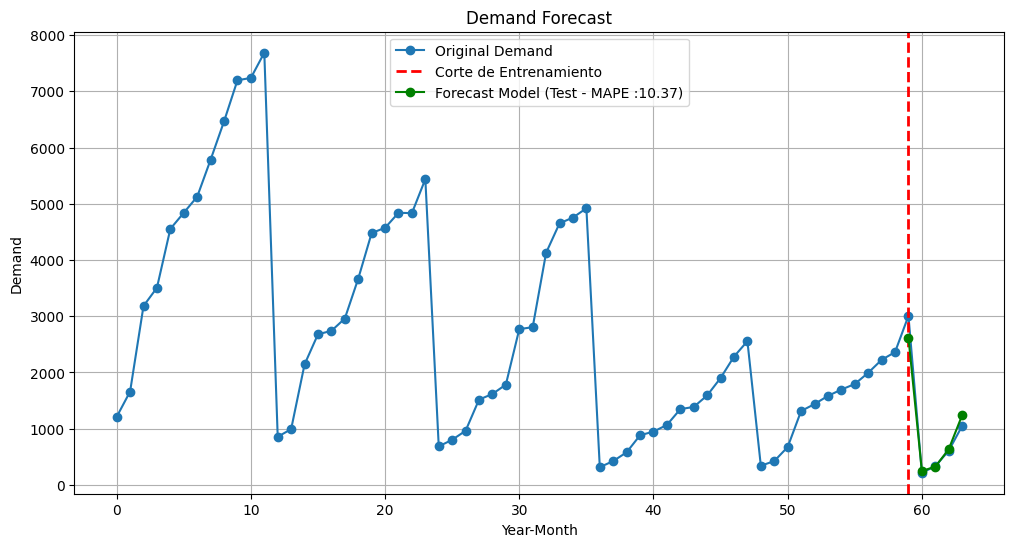

***************************************************
***************************************************
***************************************************
***************************************************

Tamaño del conjunto de prueba: 6 Entrenamiento: 58
***************************************************
***************************************************
***************************************************
***************************************************
***************************************************
***************************************************

Tamaño del conjunto de prueba: 12 Entrenamiento: 52
***************************************************
***************************************************
***************************************************
***************************************************
***************************************************
***************************************************


In [37]:
# Para validación con múltiples estacionalidades

seasonal_set = [3, 6, 9, 12, 24]

# Definimos el tamaño del conjunto de datos para pruebas

test_sizes = [2, 3, 4, 5, 6, 12]

# Iteramos para distintos periodos de prueba y cada valor de estacionalidad

models = []

for test_size in test_sizes:

  # Partimos los datos para pruebas y entrenamiento

  train_set = demand_ds.iloc[:-test_size]
  test_set = demand_ds.iloc[-test_size:]

  print(f"\nTamaño del conjunto de prueba: {len(test_set)} Entrenamiento: {len(train_set)}")

  print(f"***************************************************")

  for seasonal_period in seasonal_set:

    model = SARIMAX(train_set['Demand'], order=(p,d,q), seasonal_order=(P,D,Q,seasonal_period))

    results = model.fit()

    forecast = results.forecast(steps=test_size)

    mae = mean_absolute_error(test_set['Demand'], forecast)
    rmse = np.sqrt(mean_squared_error(test_set['Demand'], forecast))
    mape = mean_absolute_percentage_error(test_set['Demand'], forecast[:test_size]) * 100

    ##graph_scenario(demand_ds, forecast)

    green = "\033[92m"
    yellow = "\033[91m"

    #print(f"{green}" if mape < 20 else f"{yellow}")
    #print(f"Period {seasonal_period} | MAE: {mae:.2f} - RMSE: {rmse:.2f} - MAPE: {mape:.2f}")

    if mape < 20:
      graph_scenario(demand_ds, forecast, mape)

      models.append({
          'period': seasonal_period,
          'model': results,
          'mape' : mape,
          'rmse' : rmse,
          'maes' : mae,
          'comments' : f"Best Model for period {seasonal_period} prediction"
      })

    print(f"***************************************************")




In [ ]:
[print (model['comments']) for model in models]

Best Model for period 6 prediction
Best Model for period 12 prediction
Best Model for period 12 prediction
Best Model for period 6 prediction


[None, None, None, None]

Mejores modelos con SARIMA:


*   Para 2 Meses: MAPE -> 7.27
*   Para 3 Meses: MAPE -> 9.94
*   Para 5 Meses: MAPE -> 10.37



# **Intento con Prophet**

In [11]:
!pip uninstall prophet -y
!pip install prophet[cmdstanpy]

Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 132.4 MB/s eta 0:00:00


In [12]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [13]:
df = demand_ds.copy()
df['year_month'] = pd.to_datetime(df['year_month'])

df_prophet = df.rename(columns={'year_month': 'ds', 'Demand': 'y'})

In [14]:
df_prophet.head()

,ds,y
0,2017-01-01,1211.009490
1,2017-02-01,1660.584649
2,2017-03-01,3182.587014
3,2017-04-01,3506.515270
4,2017-05-01,4554.082280


In [15]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.5, # Mejor valor
)

m.fit(df_prophet)


In [16]:
future = m.make_future_dataframe(periods=5, freq='MS')
future.tail()

,ds
64,2022-05-01
65,2022-06-01
66,2022-07-01
67,2022-08-01
68,2022-09-01


In [17]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
64,2022-05-01,1091.974871,920.628307,1265.523130
65,2022-06-01,1168.490704,985.780937,1348.496569
66,2022-07-01,1460.072947,1234.331685,1708.019621
67,2022-08-01,1632.553416,1346.351504,1989.406444
68,2022-09-01,1926.951912,1454.867048,2457.126679


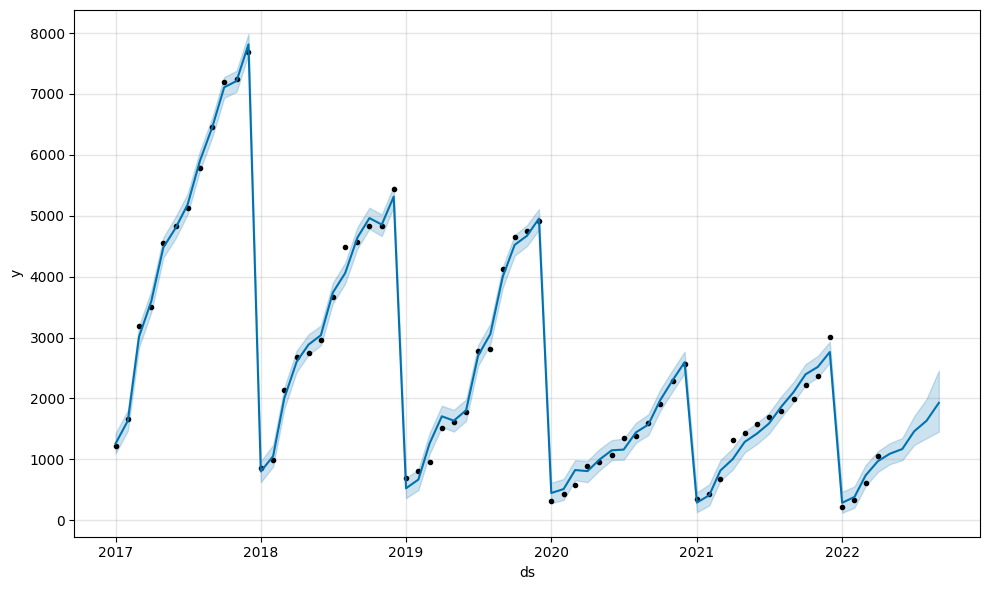

In [18]:
fig1 = m.plot(forecast)

Evaluación del Modelo

In [19]:
test_size = 3

train_df = df_prophet.iloc[:-test_size]
test_df = df_prophet.iloc[-test_size:]

In [20]:
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])][['ds', 'yhat']].reset_index(drop=True)
test_results = test_df.merge(forecast_test, on='ds')

In [21]:
# Calcular métricas
mae_1 = mean_absolute_error(test_results['y'], test_results['yhat'])
rmse_1 = np.sqrt(mean_squared_error(test_results['y'], test_results['yhat']))
mape_1 = mean_absolute_percentage_error(test_results['y'], test_results['yhat']) * 100

In [22]:
print(f"\nMétricas en Test Set (acumulado):")
print(f"  MAE:  {mae_1:,.2f}")
print(f"  RMSE: {rmse_1:,.2f}")
print(f"  MAPE: {mape_1:.2f}%")

print(f"\nComparación Real vs Predicho:")
test_results['error'] = test_results['y'] - test_results['yhat']
test_results['error_pct'] = (test_results['error'] / test_results['y']) * 100
print(test_results[['ds', 'y', 'yhat', 'error', 'error_pct']].to_string(index=False))


Métricas en Test Set (acumulado):
  MAE:  84.83
  RMSE: 90.61
  MAPE: 14.43%

Comparación Real vs Predicho:
        ds           y       yhat       error  error_pct
2022-02-01  332.062614 381.983897  -49.921283 -15.033696
2022-03-01  609.119726 736.033953 -126.914227 -20.835678
2022-04-01 1048.486287 970.818903   77.667384   7.407573


Text(0, 0.5, 'Demanda Acumulada')

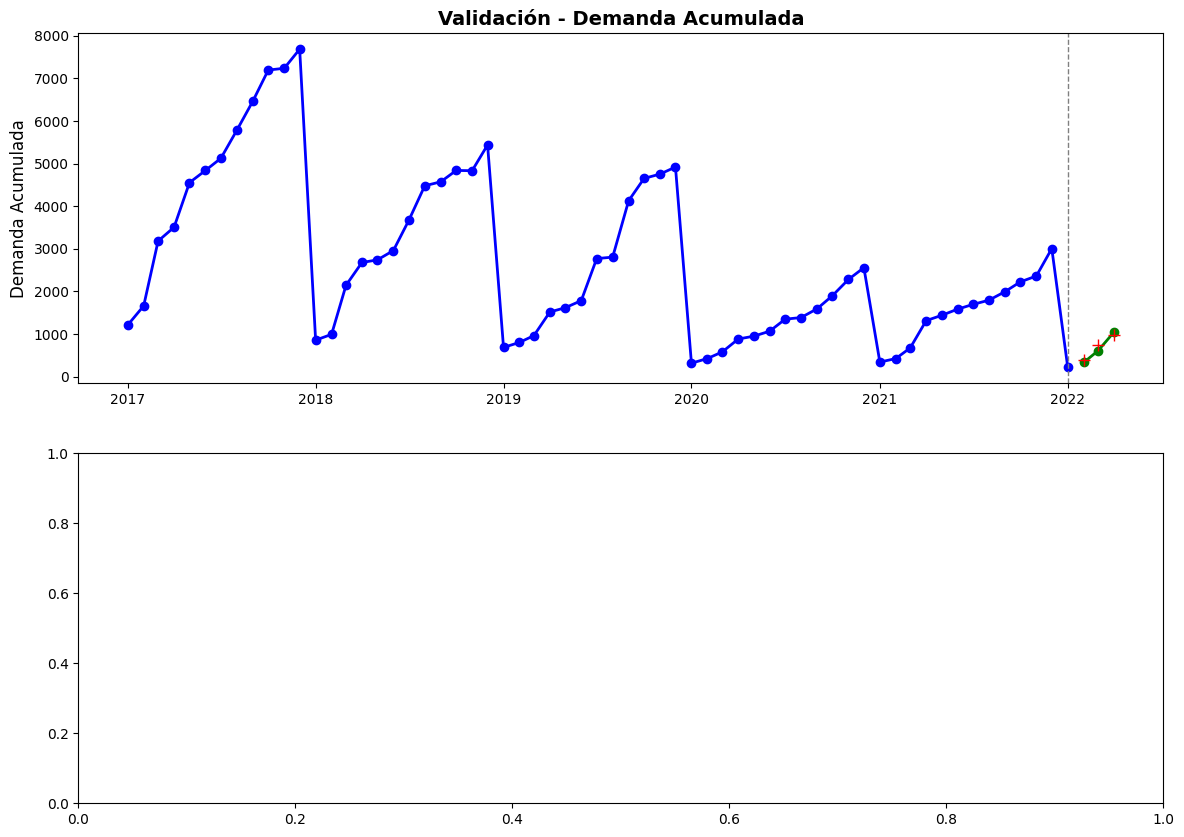

In [23]:
# Visualización de predicción.

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfica 1: Acumulado
ax1 = axes[0]
ax1.plot(train_df['ds'], train_df['y'], 'o-', label='Train (Real)', color='blue', linewidth=2)
ax1.plot(test_df['ds'], test_df['y'], 'o-', label='Test (Real)', color='green', linewidth=2)
ax1.plot(test_results['ds'], test_results['yhat'], '+', label='Predicción', color='red', linewidth=2, markersize=8)
ax1.axvline(x=train_df['ds'].max(), color='gray', linestyle='--', linewidth=1, label='Train/Test Split')
ax1.set_title('Validación - Demanda Acumulada', fontsize=14, fontweight='bold')
ax1.set_ylabel('Demanda Acumulada', fontsize=12)

Evaluación:

- Si bien Prophet Prophet presenta una región de ajuste muy pequeña con respecto a los datos. el cono de incertidumbre se ensancha para un periodo > 2 meses. Por lo cual SARIMA es el modelo que mejor se ajusta para periodos cortos de hasta 5 meses